In [1]:
!pip install cvxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.9 MB/s eta 0:00:00a 0:00:01


In [2]:
## bayes

import numpy as np
import math

from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import dirichlet

def log_lkd(x, w, theta):
    """
    log-likelihood of samples

    Args:
    x: samples
    w: weight vector
    theta: centers
    """
    k = len(w)
    n = len(x)
    lkd_mtx = np.ones((n,k))
    for j in range(k):
        lkd_mtx[:,j] = w[j]*norm.pdf(x, loc=theta[j])         
    lkd = np.sum(lkd_mtx, axis=1)
    return np.sum(np.log(lkd))

def log_prior(w, interval, lam, kappa):
    """
    log of prior density

    Args:
    w: weight vector
    interval: range of centers
    lam: mean parameter of  Poisson prior
    kappa: hyperparameter for Dirichlet prior
    """
    k = len(w)
    k_p = poisson.logpmf(k-1, lam)
    if k>1:
        w_p = dirichlet.logpdf(w, kappa*np.ones(k))  
    else:
        w_p = 0
    theta_p = -k*np.log(interval[1]-interval[0])
    return k_p + w_p + theta_p + math.lgamma(k+1)


def bayesGM(x, interval, lam, kappa, n_save, n_burn, n_thin):
    """
    RJMCMC sampler for Bayesian mixture

    Args:
    x: samples
    interval: range of centers
    lam: mean parameter of  Poisson prior
    kappa: hyperparameter for Dirichlet prior
    n_save, n_burn, n_thin: numbers of saved, burn-in and thinned MCMC samples, resp.
    """
    
    n_iter = n_burn + n_save*n_thin    
    k_mcmc = []
    theta_mcmc = []
    w_mcmc = []  
    
    ## initialize
    w = dirichlet.rvs(np.ones(6))[0]
    theta = np.random.uniform(interval[0], interval[1], size=6) 
    oll = log_lkd(x, w, theta)
    olp = log_prior(w, interval, lam, kappa)
    
    for t in range(n_iter):
        
        OK = True
        move = np.random.choice([1,2,3,4])
        k = len(w)
        
        if move==1: # add a component   
            j = np.random.choice(np.arange(k))
            w_s = np.random.uniform(0, w[j], size=1)[0]
            w1 = np.append(w, w_s)
            w1[j] = w[j] - w_s                     
            theta_s = np.random.uniform(interval[0], interval[1], size=1)[0]
            theta1 = np.append(theta, theta_s)
            log_rho_d = -np.log(k)
            log_rho_n = -np.log(k*(k+1))
            log_q_d = -np.log(interval[1]-interval[0]) - np.log(w1[j])
            log_q_n = 0
        
        if move==2: #delete a component     
            if k > 1:
                jh = np.random.choice(np.arange(k), 2, replace=False)
                j = jh[0]
                h = jh[1]
                w1 = w.copy()
                w1[j] = w[j] + w[h]                
                w1 = np.delete(w1, h)                
                theta1 = np.delete(theta, h) 
                log_rho_d = -np.log(k*(k-1))
                log_rho_n = -np.log(k-1)
                log_q_d = 0
                log_q_n = -np.log(interval[1]-interval[0]) - np.log(w[j]+w[h])
            else:
                OK = False
        
        if move==3: # sample theta
            j = np.random.choice(np.arange(k))
            theta1 = theta.copy()
            theta1[j] = np.random.uniform(interval[0], interval[1], size=1)[0]
            w1 = w.copy()
            log_rho_d = log_rho_n = log_q_d = log_q_n = 0        
        
        if move==4: #sample w
            if k > 1:
                jh = np.random.choice(np.arange(k), 2, replace=False)
                j = jh[0]
                h = jh[1]
                w1 = w.copy()
                w1[j] = np.random.uniform(0, w[j] + w[h], size=1)[0]
                w1[h] = w[j] + w[h] - w1[j]
                theta1 = theta.copy()
                log_rho_d = log_rho_n = log_q_d = log_q_n = 0    
            else:
                OK = False          
                
        if OK:            
            nll = log_lkd(x, w1, theta1)
            nlp = log_prior(w1, interval, lam, kappa)            
            MHR = nll + nlp - oll - olp + log_rho_n - log_rho_d + log_q_n - log_q_d 
            
            if np.log(np.random.uniform(size=1))<MHR:
                w = w1.copy()
                theta = theta1.copy()
                oll = nll.copy()
                olp = nlp.copy()              
                
        if (t+1>n_burn) & ((t+1-n_burn)%n_thin==0):
            theta_mcmc.append(theta)
            w_mcmc.append(w)
            k_mcmc.append(len(w))
            
    return theta_mcmc, w_mcmc, k_mcmc


In [3]:
## discrete_rv

"""
module for common operations on discrete random variables (distributions)
"""


import numpy as np

# Affiche un message d'erreur si deux éléments n'ont pas la même shape
def assert_shape_equal(x_var, y_var):
    """
    Assert shape equal
    """
    if x_var.shape != y_var.shape:
        raise AssertionError('Shape mismatch!')


class DiscreteRV:
    """ class for 1-d finite discrete RV
    """
    def __init__(self, w, x):
        """
        weights: probabilites masses
        atoms: atoms
        """
        self.weights = np.asarray(w)
        self.atoms = np.asarray(x)
        assert_shape_equal(self.weights, self.atoms)

    
    # Méthode de classe qui permet d'afficher les atomes et les poids
    def __repr__(self):
        return "atom: %s\nwght: %s" % (self.atoms, self.weights)

    # Fonction qui calcul tout les moments jusqu'à l'ordre "degree"
    def moment(self, degree=1):
        """ Compute the moments of the input randim variable up to the given degree (start from first degree)
        Args:
        degree: int
        highest degree k

        Returns:
        array of moments from the first degree to degree k
        """
        moments = np.zeros(degree)
        monomial = np.ones(self.atoms.shape)

        for i in range(degree):
            monomial *= self.atoms # On actualise le moment, x devient x², puis x^3 etc...
            moments[i] = np.dot(self.weights, monomial) # Calcul du moment

        return moments

    # Calcul la distance de Wasserstein entre une variable aléatoire et une autre.
    # La distance de Wasserstein ne se calcul pas entre des mesures plutôt ???
    def dist_w1(self, another_rv):
        """
        Compute the W1 distance from another_rv
        """
        return wass(self, another_rv)

    # Génère num données à partir de la proba de la classe
    def sample(self, num):
        """ draw n iid sample from U
        library: https://docs.scipy.org/doc/numpy/reference/routines.random.html
        alternative way: scipy.stats.rv_discrete(name='custm', values=(xk, pk))
        """
        ## for 1-d RV
        return np.random.choice(self.atoms, size=num, replace=True, p=self.weights)
        # On choisi des élément au hasard, parmis les éléments 'self.atoms', on en prends un nombre 'num', 
        # on fait un tirage avec remise (replace=True) pour avoir un échantillon iid, et les probas de tirer tel ou tel atoms sont définis par 'p=self.weights'
        

        ## for U in higher dimensions
        # return U.x[np.random.choice(U.x.shape[0],size=n, replace=True, p=U.p)]


    # Génère num données de la loi donnée dans la classe, en ajoutant un bruit gaussien de moyenne 0, et de variance 1 (la variance est modifiable par le paramètre sigma)
    def sample_noisy(self, num, sigma=1):
        """ draw n iid samples from model U+sigma Z. Default sigma=1.
        """
        return self.sample(num) + sigma*np.random.randn(num)


## Attention, on sort du cadre de la classe


# Calcul la distance de wasserstein entre deux variables aléatoires discrètes
def wass(u_rv, v_rv):
    """ compute W1 distance between DiscreteRVs U and V
    """
    if len(u_rv.atoms) == 0 or len(v_rv.atoms) == 0:
        return 0.

    x_u, p_u = zip(*sorted(zip(u_rv.atoms, u_rv.weights)))
    x_v, p_v = zip(*sorted(zip(v_rv.atoms, v_rv.weights)))
    l_u, l_v, diff_cdf, dist, pre = 0, 0, 0., 0., 0.
    while l_u < len(x_u) or l_v < len(x_v):
        if l_v == len(x_v) or (l_u < len(x_u) and x_v[l_v] > x_u[l_u]):
            dist += abs(diff_cdf)*(x_u[l_u]-pre)
            pre = x_u[l_u]
            diff_cdf += p_u[l_u]
            l_u += 1
        else:
            dist += abs(diff_cdf)*(x_v[l_v]-pre)
            pre = x_v[l_v]
            diff_cdf -= p_v[l_v]
            l_v += 1

    return dist


In [4]:
## dmm

# Denoised Methods Moments : On utilise la méthode de l'estimation de paramètres, avec la méthode des moments, dans le cas de données bruités. On commence par débruiter les données, puis on applique la méthode des moments

"""
main module
"""
import numpy as np
import moments as mm
from model_gm import ModelGM

    # input: samples
    # output: estimated model
    # provide some optional parameters


    # known variance
    ## given weighting matrix
    ## no weighting matrix
    ### 1. use identity weighting matrix
    ### 2. consistent estimation of optimal weighting matrix
    ### 3. re-estimate


    # unknown variance
# La classe estime des paramètres de distribution (principalement des moments d'une distribution), avec une approche de "dénaturation" ou de nettoyage des moments.
class DMM():
    """
    class for denoised method of moments
    """
    def __init__(self, k, interval=None, sigma=None):
        """
        Args:
        sigma: float, default None
        standard deviation. If sigma == None, will estimate sigma.

        interval =[a,b]: floats, default [-10, 10]
        represents the interval of means [a,b]

        num_components: int, required
        number of postulated components
        """
        if interval is None:
            interval = [-10, 10]

        self.sigma = sigma
        self.k = k
        self.interval = interval # Défini les bornes des moyennes ie plage d'estimation des moments

        # Si sigma est fourni, on ajuste le nombre de moments à calculer à 2k-1 et on prépare une transformation Hermite (via mm.hermite_transform_matrix), ce qui peut être une méthode de transformation pour "nettoyer" ou ajuster les moments bruités.
        #Si sigma n'est pas fourni, le nombre de moments à calculer est 2k, et les moments sont estimés sans transformation Hermite.
        if self.sigma is None:
            self.num_mom = 2*self.k
        else:
            self.num_mom = 2*self.k-1
            self.transform = mm.hermite_transform_matrix(2*self.k-1, self.sigma)

        # for online estimation
        # if sigma is None, this stores list of (sample size, raw moments)
        # if sigma is known, this store list of (sample size, Hermite moments, correlation)
        if self.sigma is None:
            self.online = [0, np.zeros((self.num_mom, 1))]
        else:
            self.online = [0, np.zeros((self.num_mom, 1)), np.zeros((self.num_mom, self.num_mom))]


    def estimate(self, samples):
        """
        estimate a model from given samples
        use two-step estimate:
        1.(a) prelimnary estimation with identity weight matrix
          (b) estimation of optimal weight matrix (require all samples)
        2.    reestimate parameters using estimated weight matrix

        Args:
        samples: array of float, required
        samples collected

        Returns:
        an estimated ModelGM
        """
        samples = np.asarray(samples)
        m_raw = mm.empirical_moment(samples, self.num_mom) # Calcul tout les moments empiriques jusqu'au moment self.num_mom
        # On part de plusieurs plusieurs échantillons ? Donc on obtient une matrice ? Avec les moments selon l'échantillon ?

        if self.sigma is None:
            m_raw = np.mean(m_raw, axis=1) # Estimation moyenne des moments
            m_esti, var_esti = mm.deconvolve_unknown_variance(m_raw) # Retourne une estimation de la variance, et les moments estimés, corrigés de la variance
            dmom_rv = mm.quadmom(m_esti[:2*self.k-1])  # Fonction qui convertit les moments estimés en paramètres du modèle.
            return ModelGM(w=dmom_rv.weights, x=dmom_rv.atoms, std=np.sqrt(var_esti))
        else:
            m_hermite = np.dot(self.transform[0], m_raw)+self.transform[1] #Transformation Hermite pour prendre en compte la variance dans les moments
            m_decon = np.mean(m_hermite, axis=1) # Moyenne des moments transformés
            dmom_rv = self.estimate_from_moments(m_decon) # Estimation préliminaire des paramètres à partir des moments estimés
            wmat = estimate_weight_matrix(m_hermite, dmom_rv) # Estimation de la matrice des poids
            dmom_rv = self.estimate_from_moments(m_decon, wmat) # On estime à nouveau les paramètres, à partir des poids, et des moments
            # print(np.linalg.inv(wmat))
            return ModelGM(w=dmom_rv.weights, x=dmom_rv.atoms, std=self.sigma)


    # Mets à jour l'estimation d'un modèle à partir de nouveaux échantillons
    def estimate_online(self, samples_new):
        """
        update the estimate a model from more samples
        only store a few moments and correlations

        Args:
        samples_new: array of floats
        new samples

        Returns:
        an estimated ModelGM
        """
        samples_new = np.asarray(samples_new)
        m_new = mm.empirical_moment(samples_new, self.num_mom) # moments, shape (L,n)
        n_new = len(samples_new) # Nombre d'échantillons nouveaux que l'on va traiter
        n_total = self.online[0]+n_new # Mise à jour du nombre total d'échantillon traité

        if self.sigma:
            m_new = np.dot(self.transform[0], m_new)+self.transform[1]
            cor_new = np.dot(m_new, m_new.T)/n_new
            self.online[2] = self.online[2]*(self.online[0]/n_total)+cor_new*(n_new/n_total)

        mom_new = np.mean(m_new, axis=1)[:, np.newaxis] # empirical moments, shape (L,1)
        self.online[1] = self.online[1]*(self.online[0]/n_total)+mom_new*(n_new/n_total)
        self.online[0] = n_total

        if self.sigma is None:
            m_esti, var_esti = mm.deconvolve_unknown_variance(self.online[1])
            dmom_rv = mm.quadmom(m_esti[:2*self.k-1])
            return ModelGM(w=dmom_rv.weights, x=dmom_rv.atoms, std=np.sqrt(var_esti))
        else:
            wmat = np.linalg.inv(self.online[2]-np.dot(self.online[1], self.online[1].T))
            dmom_rv = self.estimate_from_moments(self.online[1].reshape(self.num_mom), wmat)
            # print(np.linalg.inv(wmat))
            return ModelGM(w=dmom_rv.weights, x=dmom_rv.atoms, std=self.sigma)

    def estimate_with_wmat(self, samples, wmat=None):
        """
        estimate a model from given samples using given weight matrix
        model: X=U+sigma*Z
        sigma must be given

        Args:
        samples: array of float, required
        samples collected

        wmat: array of shape (k,k)
        weight matrix, default identity

        Returns:
        latent distribtuion
        """
        assert self.sigma

        m_latent = self.estimate_latent_moments(samples)
        dmom_rv = self.estimate_from_moments(m_latent, wmat)
        return ModelGM(w=dmom_rv.weights, x=dmom_rv.atoms, std=self.sigma)

    def estimate_select(self, samples, threhold=1):
        """
        estimate with selected number of components
        """
        k_cur = min(self.select_num_comp(samples, threhold), self.k)
        dmm_cur = DMM(k=k_cur, interval=self.interval, sigma=self.sigma)
        return dmm_cur.estimate(samples)

    def estimate_latent_moments(self, samples):
        """
        estimate moments of latent distribution (deconvolution)
        model: X=U+sigma*Z
        sigma must be given

        Args:
        samples: array of length n

        Return:
        array of length 2k-1
        estimated moments of U from degree 1 to 2k-1
        """
        assert self.sigma

        samples = np.asarray(samples)
        m_raw = mm.empirical_moment(samples, self.num_mom)
        m_raw = np.mean(m_raw, axis=1).reshape((self.num_mom, 1))
        return ((np.dot(self.transform[0], m_raw)+self.transform[1])).reshape(self.num_mom)

    def estimate_from_moments(self, moments, wmat=None):
        """
        estimate a discrete random variable from moments estimate

        Args:
        moments: array of length 2k-1
        estimated moments of U of degree 1 to 2k-1

        wmat: matrix of shape (k, k)
        weight matrix for moment projection, default identity matrix

        Returns:
        an estimated latent distribtuion on at most k points
        """
        m_proj = mm.projection(moments, self.interval, wmat)
        dmom_rv = mm.quadmom(m_proj, dettol=0)
        return dmom_rv

    def sample_moment_cov(self, samples):
        """
        return the sample covariance matrix of moments estimates
        """
        samples = np.asarray(samples)
        mom = mm.empirical_moment(samples, self.num_mom) # moments, shape (L,n)
        mean = np.mean(mom, axis=1)
        num = len(samples)
        cor = np.dot(mom, mom.T)/num - np.outer(mean, mean)
        return cor

    def select_num_comp(self, samples, threhold=1):
        """
        select the number of components
        according to sample variance of moments estimate
        """
        samples = np.asarray(samples)
        num = len(samples)

        m_raw = np.ones(len(samples))
        deg_cur = 0
        while True:
            deg_cur += 1
            m_raw *= samples
            var = np.mean(m_raw**2)-np.mean(m_raw)**2
            if var > threhold*num:
                break

        # moments of degree 1 to (deg_cur-1) is accurate
        if self.sigma:
            return int(np.floor(deg_cur/2))
        else:
            return int(np.floor((deg_cur-1)/2))

def estimate_weight_matrix(m_estimate, model):
    """
    estimate weight matrix: inverse of the estimated covariance matrix
    ref: [Bruce E. Hansen] Econometrics. Chapter 11.

    Args:
    m_estimate: matrix of size (k,n)
    power of n samples from degree of 1 to k

    model: discrete_rv

    Return:
    consistent estimation for the optimal weight matrix
    """
    num_moments, num_samples = m_estimate.shape
    mom_model = model.moment(num_moments).reshape((num_moments, 1))
    m_cond = m_estimate - mom_model
    m_cond_avg = np.mean(m_cond, axis=1).reshape((num_moments, 1))
    m_cond_centd = m_cond - m_cond_avg
    return np.linalg.inv(np.dot(m_cond_centd, m_cond_centd.T)/num_samples)


In [5]:
## DP

import numpy as np
#from nn_model_fts import *
from scipy.stats import norm
from scipy.stats import truncnorm


def DP(x, interval, kappa, n_save, n_burn, n_thin):
    
    n_iter = n_burn + n_save*n_thin    
    k_mcmc = []
    theta_mcmc = []
    
    n = len(x)
    K_new=5
    ## initialize
    theta = np.random.uniform(interval[0], interval[1], size=6) 
    z = np.random.choice(np.arange(6)+1, size=n)
    
    for t in range(n_iter):
        
        for i in range(n):
            T = np.max(z)
            z_i = np.delete(z, i)
            theta_new = np.random.uniform(interval[0], interval[1], size=K_new)             
            
            unnorm_prob = np.zeros(T+K_new)
            for j in range(T+K_new):
                if j < T:
                    unnorm_prob[j] = np.sum(np.equal(z,j+1))*norm.pdf(x[i], loc=theta[j])   
                else:
                    unnorm_prob[j] = kappa*norm.pdf(x[i], loc=theta_new[j-T])/K_new      
                    
            prob =  unnorm_prob/np.sum(unnorm_prob)
            z_new = np.random.choice(np.arange(T+K_new) + 1, p=prob)
            
            if np.sum(np.equal(z_i, z[i]))>0: 
                if z_new > T:
                    z[i] = T + 1 
                    theta = np.append(theta, theta_new[z_new-T-1])
                else:
                    z[i] = z_new 
                    
            else: 
                if z_new > T:
                    theta[z[i]-1] = theta_new[z_new-T-1]
                else:
                    if z_new !=z[i]:
                        z_old = z[i]
                        z[i] = z_new
                        theta = np.delete(theta, z_old-1)                        
                        z = z - (np.array(z)>z_old)                             
            
        T = np.max(z)    
        for j in range(T):
            x_j = x[np.equal(z, j+1)]
            theta[j] = truncnorm.rvs(interval[0], interval[1], loc=np.mean(x_j), scale=1/np.sqrt(len(x_j)))      
                
        if (t+1>n_burn) & ((t+1-n_burn)%n_thin==0):
            theta_mcmc.append(theta)
            k_mcmc.append(len(np.unique(z)))
            
    return theta_mcmc,  k_mcmc

In [6]:
## em_bayes

import numpy as np
from model_gm import ModelGM

class EM():

    def __init__(self, k, sigma=None, interval=[-5,5], tol=1e-3, max_iter=100, print_iter=False):

        self.k = k
        self.sigma = sigma
        self.tol = tol
        self.max_iter = max_iter
        self.print_iter = print_iter
        self.interval = interval

    def estimate(self, samples, num_rd=5, x_range=None, s_range=None):
        """
        estimate a model
        best of num_rd random initial guesses
        initial centers are uniform from x_range
        initial sigma are uniform from s_range

        Args:
        num_rd(int): number of random initial guess, default 5
        x_range [a,b]: initial guess range of centers, default [-1,1]
        s_range [c,d]: initial guess range of sigmas, default [0.5,1.5]
        """
        if x_range is None:
            x_range = [-1, 1]
        if s_range is None:
            s_range = [0.5, 1.5]

        ll_max = float('-inf')
        for _ in range(num_rd):
            w_init = np.random.dirichlet(np.ones(self.k))
            x_init = np.random.uniform(x_range[0], x_range[1], self.k)
            if self.sigma is None:
                s_init = np.random.uniform(s_range[0], s_range[1])
            else:
                s_init = self.sigma
            start = ModelGM(w=w_init, x=x_init, std=s_init)
            model_cur, _, ll_cur = self.estimate_with_init(samples, start, detail=True)
            if ll_cur > ll_max:
                model = model_cur
                ll_max = ll_cur
        return model

    def estimate_with_init(self, samples, init, detail=False):
        """
        estimate a model from a given initial
        Args:
        init (modelGM): initial guess

        Returns:
        model(modelGM): estimated model
        iterN(int): number of iterations
        ll_cur(float): last log-likelihood
        """
        # assert self.k == len(init.weights)
        k_cur = len(init.weights)
        num = len(samples)
        samples = np.asarray(samples)

        num_iter = 0
        model = init
        l_mat = np.exp(ll_mat(samples, model)) # shape (n,k)
        ll_cur = np.sum(np.log(np.dot(l_mat, model.weights)))

        while True:
            ll_pre = ll_cur

            labels = l_mat * model.weights # shape (n,k)
            labels /= np.sum(labels, axis=1)[:, np.newaxis]

            sum_labels = np.sum(labels, axis=0) # shape (k,)

            num_iter += 1
            model.weights = (sum_labels+1)/(num+self.k)
            centers = np.dot(samples, labels)/sum_labels
            centers[centers>self.interval[1]] = self.interval[1]
            centers[centers<self.interval[0]] = self.interval[0]
            model.centers = centers

            if self.sigma is None:
                # EM iteration of estimating the common variance
                cross = model.centers**2-2*np.outer(samples, model.centers)\
                        +(samples**2)[:, np.newaxis]
                sigma2 = np.sum(cross*labels)/num
                model.sigma = np.ones(k_cur) * np.sqrt(sigma2)

            l_mat = np.exp(ll_mat(samples, model))
            ll_cur = np.sum(np.log(np.dot(l_mat, model.weights)))

            if self.print_iter:
                print(model.weights, model.centers, model.sigma)
                print(ll_cur)

            if num_iter > self.max_iter or ll_cur-ll_pre < self.tol:
                break

        if detail:
            return model, num_iter, ll_cur
        else:
            return model

def ll_mat(samples, model):
    """
    log-likelihood of samples

    Args:
    samples: ndarray of length n
    model: ModelGM instance of k components with common sigma

    Returns:
    matrix of log-likelihoods of shape (n,k)
    """
    samples = np.asarray(samples)
    precision = 1./(model.sigma**2) # inverse of variance (sigma^2)
    ll0 = model.centers**2*precision - 2*np.outer(samples, model.centers*precision) \
          +np.outer(samples**2, precision)
    return -0.5*(np.log(2*np.pi)+ll0)-np.log(model.sigma)


def ll_sample(samples, model):
    """
    Log-likelihood matrix of samples under the given GM model

    Args:
    samples: ndarray of length n
    model: ModelGM instance of k components with common sigma

    Return:
    log-likelihood of all samples
    """
    return np.sum(np.log(np.dot(np.exp(ll_mat(samples, model)), model.weights)))


def em_msel(x, kmin, kmax, kexact, interval, lam1, lam2, kappa):
    """
    Model selection for Bayesian mixtures

    Args:
    samples: ndarray of length n
    kmin, kmax: minimum and maximum number of components
    kexact: true number of compoents
    inteval: range of centers
    lam1, lam2: two choices for mean parameter of Poisson prior
    kappa: hyperparameter for Dirichlet prior
    """
    est_list = []
    post_list1 = []
    post_list2 = []
    for k in range(kmin, kmax+1):
        em = EM(k=k, sigma=1)
        est = em.estimate(x)
        est_list.append(est)
        log_lkd_val = log_lkd(x, est.weights, est.centers)
        post_list1.append(log_lkd_val+log_prior(est.weights, interval, lam1, kappa))
        post_list2.append(log_lkd_val+log_prior(est.weights, interval, lam2, kappa))
        
    k_map1 = np.argmax(post_list1)
    k_map2 = np.argmax(post_list2)
    
    return  est_list[kexact-kmin], est_list[kmax-kmin], est_list[k_map1], est_list[k_map2]
        

In [7]:
## model_gm

"""
module for Gaussian mixture model
"""
from discrete_rv import DiscreteRV, assert_shape_equal
from moments import hermite_transform_matrix, empirical_moment
import numpy as np

class ModelGM:
    """ class for 1-d Gaussian mixture model
    weights: ndarray of weights
    centers: ndarray of means
    sigma: standard deviations
    """
    def __init__(self, w=1, x=0, std=1):
        """ Initialize a GM model
        w: arrary of weights
        x: arrary of means
        std: scalar or array of standard deviations. If scalar, components share the same std.
        """

        self.weights = np.asarray(w)
        self.centers = np.asarray(x)
        assert_shape_equal(self.weights, self.centers)
        # np.testing.assert_array_equal(self.p.shape, self.mu.shape)
        
        if np.isscalar(std):
            self.sigma = std*np.ones(self.weights.shape)
        else:
            self.sigma = np.asarray(std)
        assert_shape_equal(self.weights, self.sigma)

    def __repr__(self):
        return "atom: %s\nwght: %s\nsigm: %s" % (self.centers, self.weights, self.sigma[0])

    def moments_gm(self, degree):
        """
        moments of GM model

        Args:
        degree: int
        highest degree k

        Returns:
        moments of Gaussian mixture model from degree 1 to k
        """
        mom = empirical_moment(self.centers/self.sigma, degree)
        transform = hermite_transform_matrix(degree)
        transform = (np.abs(transform[0]), np.abs(transform[1]))
        mom = np.dot(transform[0], mom) + transform[1]
        s_pow = empirical_moment(self.sigma, degree)
        mom = s_pow*mom
        return np.dot(mom, self.weights)

    def mean_rv(self):
        """
        discrete rv for the means
        """
        return DiscreteRV(self.weights, self.centers)

    def std_rv(self):
        """
        discrete rv for the sigmas
        """
        return DiscreteRV(self.weights, self.sigma)



def sample_gm(model, num, seed):
    """
    n random samples from Gaussian mixture model
    """
    np.random.seed(seed)
    idx = np.random.choice(model.centers.shape[0], size=num, replace=True, p=model.weights)
    x = model.centers[idx] + model.sigma[idx] * np.random.randn(num)
    return x



from scipy.stats import t
import numpy as np
from discrete_rv import DiscreteRV, assert_shape_equal
import matplotlib.pyplot as plt

class ModelStudentMixture:
    """
    Class for 1-d Student's t Mixture Model
    weights: ndarray of weights
    centers: ndarray of means
    sigma: standard deviations (scale parameter of t-distribution)
    nu: degrees of freedom for the t-distribution
    """
    def __init__(self, w=1, x=0, std=1, nu=5):
        """
        Initialize a Student Mixture model
        w: array of weights
        x: array of means
        std: scalar or array of standard deviations. If scalar, components share the same std.
        nu: scalar or array of degrees of freedom. If scalar, components share the same nu.
        """
        self.weights = np.asarray(w)
        self.centers = np.asarray(x)
        assert_shape_equal(self.weights, self.centers)

        if np.isscalar(std):
            self.sigma = std * np.ones(self.weights.shape)
        else:
            self.sigma = np.asarray(std)
        assert_shape_equal(self.weights, self.sigma)

        if np.isscalar(nu):
            self.nu = nu * np.ones(self.weights.shape)
        else:
            self.nu = np.asarray(nu)
        assert_shape_equal(self.weights, self.nu)

    def __repr__(self):
        return "atom: %s\nwght: %s\nsigm: %s\nnu: %s" % (
            self.centers,
            self.weights,
            self.sigma[0],
            self.nu[0],
        )

    
    def moments_t(self, k):
        """
        Compute the k-th moment of the Student's t-distribution with degrees of freedom nu.
        Parameters:
            k (int): Order of the moment
            nu (float): Degrees of freedom
        Returns:
            float: k-th moment if defined, otherwise None
        """
        if self.nu <= k:
            return None  # Moment undefined for nu <= k
        coef = (2 ** (k / 2)) * gamma((k + 1) / 2) * gamma((self.nu - k) / 2)
        denom = np.sqrt(np.pi *self.nu) * gamma(self.nu / 2)
        return coef / denom
    
    def mean_rv(self):
        """
        discrete rv for the means
        """
        if np.min(self.nu) >1 :
            return DiscreteRV(self.weights, self.centers)
        else:
            raise ValueError("The degree of freedom should be higher than 1 in order that the first moment exists")

    def std_rv(self):
        """
        discrete rv for the sigmas
        """
        if np.min(self.nu) > 2:
            return DiscreteRV(self.weights, self.sigma)
        else:
            raise ValueError("The degree of freedom should be higher than 2 in order that the moment 2 exists")



# Sampler
def sample_student_mix(model, num, seed=123):
        """
        Generate n random samples from the Student's t mixture model
        """
        np.random.seed(seed)
        idx = np.random.choice(model.centers.shape[0], size=num, replace=True, p=model.weights)
        x = model.centers[idx] + model.sigma[idx] * t.rvs(model.nu[idx], size=num)
        return x

In [8]:
## moments

"""
module for operations on moments
"""

import numpy as np
import cvxpy
from scipy.linalg import hankel
from discrete_rv import DiscreteRV
import warnings

def empirical_moment(samples, degree):
    """ Compute empirical moments of samples
    Args:
    samples: x=(x1...xn)
    degree: L

    Returns
    matrix M of size L*n
    each row is the moments of (x1...xn) (start from the first degree to degree L)
    """
    m_raw = np.empty((degree, len(samples)))
    m_raw[0, :] = samples
    for i in range(1, degree):
        m_raw[i, :] = m_raw[i-1, :] * samples

    return m_raw

def hermite_transform_matrix(degree, sigma=1):
    """ Hermite transformation
    Let x=(x,...,x^k)', then Ax+b=(g_1(x,sigma),...,g_k(x,sigma))
    g_k(x,sigma)=sigma^k*H_k(x/sigma), g_k(x,1)=H_k(x), the usual Hermite polynomial

    Args:
    degree: int
    highest degree k

    Return:
    tuple (A,b): A is a matrix of shape (k,k), b is a vector of shape (k,1)
    """
    length = degree+1
    var = sigma*sigma
    mat = np.zeros((length, length))
    if length > 0:
        prepre = np.zeros(length)
        prepre[0] = 1
        mat[0, :] = prepre
    if length > 1:
        pre = np.zeros(length)
        pre[1] = 1
        mat[1, :] = pre
    for k in range(2, length):
        # recursion: H_{n+1}(x) = x * H_n(x) - n * H_{n-1}(x)
        # => g_{n+1}(x,s) = x * g_n(x,s) - n * s^2 * g_{n-1}(x,s)
        coeffs = np.roll(pre, 1) - prepre*(k-1)*var
        mat[k, :] = coeffs
        prepre = pre
        pre = coeffs

    return (mat[1:, 1:], mat[1:, 0].reshape((degree, 1)))


def transform(mat, x_var):
    """
    Compute a linear tranformation Ax+b

    mat: Tuple (A,b)
    A: matrix of shape (k,k)
    b: matrix of shape (k,1)

    x_var: variable x
    array of length k

    Returns:
    array of length k, y=Ax+b
    """
    k = len(mat)
    x_var = x_var.reshape((k, 1))
    y_var = np.dot(mat[0], x_var)+mat[1]
    return y_var.reshape(k)



def projection(moments, interval=None, wmat=None):
    """ project to a valid moment sequence on interval [a,b]

    Args:
    moments: a sequence of estimated moments, starting from degree 1
    interval [a,b]: range of distributions, default [-1,1]
    wmat: weighting matrix, default identity matrix

    Returns:
    a sequence of valid moments on [a,b], starting from degree 1 (default [a,b]=[-1,1])
    minimize (moments-x)' * wmat * (moments-x), subject to x is a valid moment sequence
    """
    if interval is None:
        interval = [-1, 1]

    length = len(moments)
    if length == 0:
        return moments
    if length == 1:
        moments[0] = max(interval[0], min(interval[1], moments[0]))
        return moments


    # preliminary filtering of moments based on range
    r_max = max(abs(interval[0]),abs(interval[1]))
    m_max = 1
    for i in range(len(moments)):
        m_max *= r_max
        if moments[i] > m_max:
            moments[i] = m_max
        elif moments[i] < -m_max:
            moments[i] = -m_max    

    # SDP for further projection
    variables = cvxpy.Variable(length) # variables [m_1,m_2,...,m_n]
    if wmat is None:
        wmat = np.identity(length)
    obj = cvxpy.Minimize(cvxpy.quad_form(moments-variables, wmat)) # objective function
    # obj = cvxpy.Minimize(cvxpy.sum_squares(x - moments)) 

    # the following gives constraints
    # Ref for PSD condition: [Lasserre 2009, Theorem 3.3 and 3.4]
    if length % 2 == 1:
        # odd case
        k = int((length+1)/2)
        h_mat = cvxpy.Variable((k, k+1))
        constraints = [h_mat[:, 1:]-interval[0]*h_mat[:, :k]>>0,
                       interval[1]*h_mat[:, :k]-h_mat[:, 1:]>>0]
    else:
        # even case
        k = int(length/2)+1
        h_mat = cvxpy.Variable((k, k))
        constraints = [h_mat>>0,
                       (interval[0]+interval[1])*h_mat[:k-1, 1:]-interval[0]*interval[1]*h_mat[:k-1, :k-1]-h_mat[1:, 1:]>>0]
    num_row, num_col = h_mat.shape
    for i in range(num_row):
        for j in range(num_col):
            if i == 0 and j == 0:
                constraints.append(h_mat[0, 0] == 1)
            else:
                constraints.append(h_mat[i, j] == variables[i+j-1])

    prob = cvxpy.Problem(obj, constraints)
    try:
        prob.solve(solver=cvxpy.CVXOPT)
    except Exception as e:
        warnings.warn("CVXOPT failed. Using SCS solver..."+str(e))
        prob.solve(solver=cvxpy.SCS)
        # prob.solve()
    # opt = prob.solve(solver=cvxpy.CVXOPT)

    return np.asarray(variables.value).reshape(moments.shape)




def quadmom(moments, dettol=0, inf=1e10):
    """ compute quadrature from moments
    ref: Gene Golub, John Welsch, Calculation of Gaussian Quadrature Rules

    Args:
    m: moments sequence
    dettol: tolerant of singularity of moments sequence (quantified by determinant of moment matrix)
    INF: infinity

    Returns:
    U: quadrature
    """

    moments = np.asarray(moments)
    # INF = float('inf')
    inf = 1e10

    if len(moments) % 2 == 1:
        moments = np.append(moments, inf)
    num = int(len(moments)/2)
    moments = np.insert(moments, 0, 1)


    h_mat = hankel(moments[:num+1:], moments[num::]) # Hankel matrix
    for i in range(len(h_mat)):
        # check positive definite and decide to use how many moments
        if np.linalg.det(h_mat[0:i+1, 0:i+1]) <= dettol: # alternative: less than some threshold
            h_mat = h_mat[0:i+1, 0:i+1]
            h_mat[i, i] = inf
            num = i
            break
    r_mat = np.transpose(np.linalg.cholesky(h_mat)) # upper triangular Cholesky factor

    # Compute alpha and beta from r, using Golub and Welsch's formula.
    alpha = np.zeros(num)
    alpha[0] = r_mat[0][1] / r_mat[0][0]
    for i in range(1, num):
        alpha[i] = r_mat[i][i+1]/r_mat[i][i] - r_mat[i-1][i]/r_mat[i-1][i-1]

    beta = np.zeros(num-1)
    for i in range(num-1):
        beta[i] = r_mat[i+1][i+1]/r_mat[i][i]

    jacobi = np.diag(alpha, 0) + np.diag(beta, 1) + np.diag(beta, -1)

    eigval, eigvec = np.linalg.eig(jacobi)

    atoms = eigval
    weights = moments[0] * np.power(eigvec[0], 2)

    return DiscreteRV(w=weights, x=atoms)


def deconvolve_unknown_variance(moments):
    """ Deconvolution with unknown sigma, using Lindsay's estimator.
    Fit moments with U+sigma Z. Estimate common sigma, and moments of U.

    Args:
    moments: array of float, length 2k
    moments estimate of degree 1 to 2k

    Returns:
    Tuple of deconvolved moments and estimated variance (sigma^2)
    """

    moments = np.insert(moments, 0, 1)

    length = len(moments)
    m_hermite = [0]*length
    x_var = np.poly1d([1, 0]) # x = sigma^2

    if length > 0:
        prepre = np.zeros(moments.shape)
        prepre[0]=1
        m_hermite[0] = moments[0]
    if length > 1:
        pre = np.zeros(moments.shape)
        pre[1]=1
        m_hermite[1] = moments[1]
    for k in range(2, length):
        # recursion: H_{n+1}(x) = x * H_n(x) - n * H_{n-1}(x)
        coeffs = np.roll(pre, 1) - prepre*(k-1)
        for i in range(k+1):
            m_hermite[k] += float(coeffs[i]*moments[i])*(x_var**(int((k-i)/2)))
        prepre = pre
        pre = coeffs

    # Solve the first non-negative root
    equation = det_mom(m_hermite)

    root = equation.r
    root = root[np.isreal(root)].real
    root = root[root >= 0]
    root.sort()
    # print(root)
    root0 = root[0]

    for k in range(2, length):
        m_hermite[k] = m_hermite[k](root0)

    return (np.asarray(m_hermite[1:]), float(root0))



def det_mom(moments):
    """
    Compute determinant of moment matrix

    Args:
    moments: array of moments of

    Return:
    determinant of moment matrix
    """
    return determinant(get_hankel(moments))


def get_hankel(moments):
    """
    Construct Hankel matrix from (m_0,...,m_{2k})

    Args:
    moments: array of floats of length 2k+1
    moments of degrees from 0 to 2k

    Return:
    Hankel matrix from those moments of size (k+1,k+1)
    """
    # length of m = 2k+1 = 2k_inc-1
    k_inc = int((len(moments)+1)/2)
    matrix = [[0]*k_inc for i in range(k_inc)]
    for i in range(k_inc):
        for j in range(k_inc):
            matrix[i][j] = moments[i+j]

    return matrix


def determinant(mat, rows=None, cols=None):
    """
    Compute the determinant of a submatrix

    Args:
    mat: matrix, list of lists
    input matrix

    rows: list of int
    selection of rows

    cols: list of int, same size as rows
    selection of columns

    Returns:
    determinant of submatrix mat[rows, cols]
    """
    if rows is None:
        num_rows, num_cols = len(mat), len(mat[0])
        rows = list(range(num_rows))
        cols = list(range(num_cols))

    num_rows = len(rows)
    num_cols = len(cols)
    assert num_rows == num_cols

    if num_rows == 1:
        return mat[rows[0]][cols[0]]
    # elif rows == 2:
    #     return M[r[0]][c[0]]*M[r[1]][c[1]] - M[r[0]][c[1]]*M[r[1]][c[0]]
    # elif rows == 3:
    #     return (M[r[0]][c[0]]*M[r[1]][c[1]]*M[r[2]][c[2]]
    #             + M[r[0]][c[1]]*M[r[1]][c[2]]*M[r[2]][c[0]]
    #             + M[r[0]][c[2]]*M[r[1]][c[0]]*M[r[2]][c[1]])
    #             - (M[r[0]][c[2]]*M[r[1]][c[1]]*M[r[2]][c[0]]
    #             + M[r[0]][c[0]]*M[r[1]][c[2]]*M[r[2]][c[1]]
    #             + M[r[0]][c[1]]*M[r[1]][c[0]]*M[r[2]][c[2]])
    else:
        det = 0
        newr = rows[1:]
        sign = 1
        for k in range(num_cols):
            newc = cols[:k] + cols[(k + 1):]
            det += determinant(mat, newr, newc)*mat[rows[0]][cols[k]]*sign
            sign *= -1
        return det

    #### Available methods for computing determinant using Sympy: bareis, berkowitz, det_LU
    #### Method 1: berkowitz
    # eq = sympy.Matrix(H).det(method='berkowitz').as_poly().expand()
    #### Method 2: bareis
    # eq = sympy.Matrix(H).det(method='bareis').as_poly()
    # for i in eq.gens[1:]:
    #     eq = eq.eval(i,1)
    # return eq

In [9]:
## test_student_mixture

!pip install cvxpy

import numpy as np
import math
import random
import matplotlib.pyplot as plt

from DP import *
from bayes import *
from em_bayes import *
from dmm import DMM
from model_student_mixture import ModelStudentMixture, sample_student_mix
from discrete_rv import wass


## Model define
model_list = []
model_list.append(ModelStudentMixture(w=[0.3, 0.2, 0.3, 0.2], x=[-3, -1, 1, 3], std=1, nu=5))
model_list.append(ModelStudentMixture(w=[0.25, 0.25, 0.25, 0.25], x=[-1.5, -1, 1, 3], std=1, nu=10))
model_list.append(ModelStudentMixture(w=[0.4, 0.1, 0.25, 0.25], x=[-3, -1, 1, 3], std=1, nu=7))
model_list.append(ModelStudentMixture(w=np.ones(7)/7, x=2*np.arange(7)-6, std=1, nu=8))

n_list = 250 * (np.arange(8) + 1)
repeat = 50
wass_list = np.zeros([4, len(n_list), 5, repeat])

for m in range(len(model_list)):    
    model = model_list[m]
    kexact = len(model.centers)
    kmax = 2 * kexact 
    kmin = 2
    
    for i, n in enumerate(n_list):         
        for b in range(repeat):
            x = sample_student_mix(model, n, seed=b)
            
            dmm = DMM(k=np.min([kexact, 4]), interval=[-7, 7], sigma=1)    
            dmm_est = dmm.estimate(x)
            map1, map2, bayes1, bayes2 = em_msel(
                x, 
                kmin, 
                kmax, 
                kexact, 
                interval=[-6, 6], 
                lam1=1, 
                lam2=np.exp(-0.05 * np.log(n)**2 / np.log(np.log(n))), 
                kappa=1
            )
            
            wass_list[m, i, 0, b] = wass(dmm_est.mean_rv(), model.mean_rv())
            wass_list[m, i, 1, b] = wass(map1.mean_rv(), model.mean_rv())
            wass_list[m, i, 2, b] = wass(map2.mean_rv(), model.mean_rv())
            wass_list[m, i, 3, b] = wass(bayes1.mean_rv(), model.mean_rv())
            wass_list[m, i, 4, b] = wass(bayes2.mean_rv(), model.mean_rv())

## PLOT

wass_mean = wass_list.mean(axis=3)
wass_std = wass_list.std(axis=3)

markers = ['^', 'o', 's', 'D', '*']
name = ['DMM', 'MAP_exact', 'MAP_over', 'MFM_const', 'MFM_vary']
    
for m in range(len(model_list)):      
    plt.figure()       
    for i in range(5): 
        plt.plot(n_list, wass_mean[m, :, i], marker=markers[i], label=name[i])        
        plt.fill_between(
            n_list, 
            wass_mean[m, :, i] - wass_std[m, :, i], 
            wass_mean[m, :, i] + wass_std[m, :, i], 
            alpha=0.2
        )
    if m == 1:
        plt.legend()
    plt.xlabel("Sample size")
    plt.ylabel("Wasserstein 1")  
    plt.savefig("student_mixture" + str(m + 1) + ".png")

/Users/pierre/Documents/ENSAE/Bayesian-stats-project/notebooks/ilsangohn/moments.py:149: UserWarning: CVXOPT failed. Using SCS solver...The solver CVXOPT is not installed.
  warnings.warn("CVXOPT failed. Using SCS solver..."+str(e))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


KeyboardInterrupt: 

Processing: 100%|██████████| 3200/3200 [45:49<00:00,  1.16it/s]  


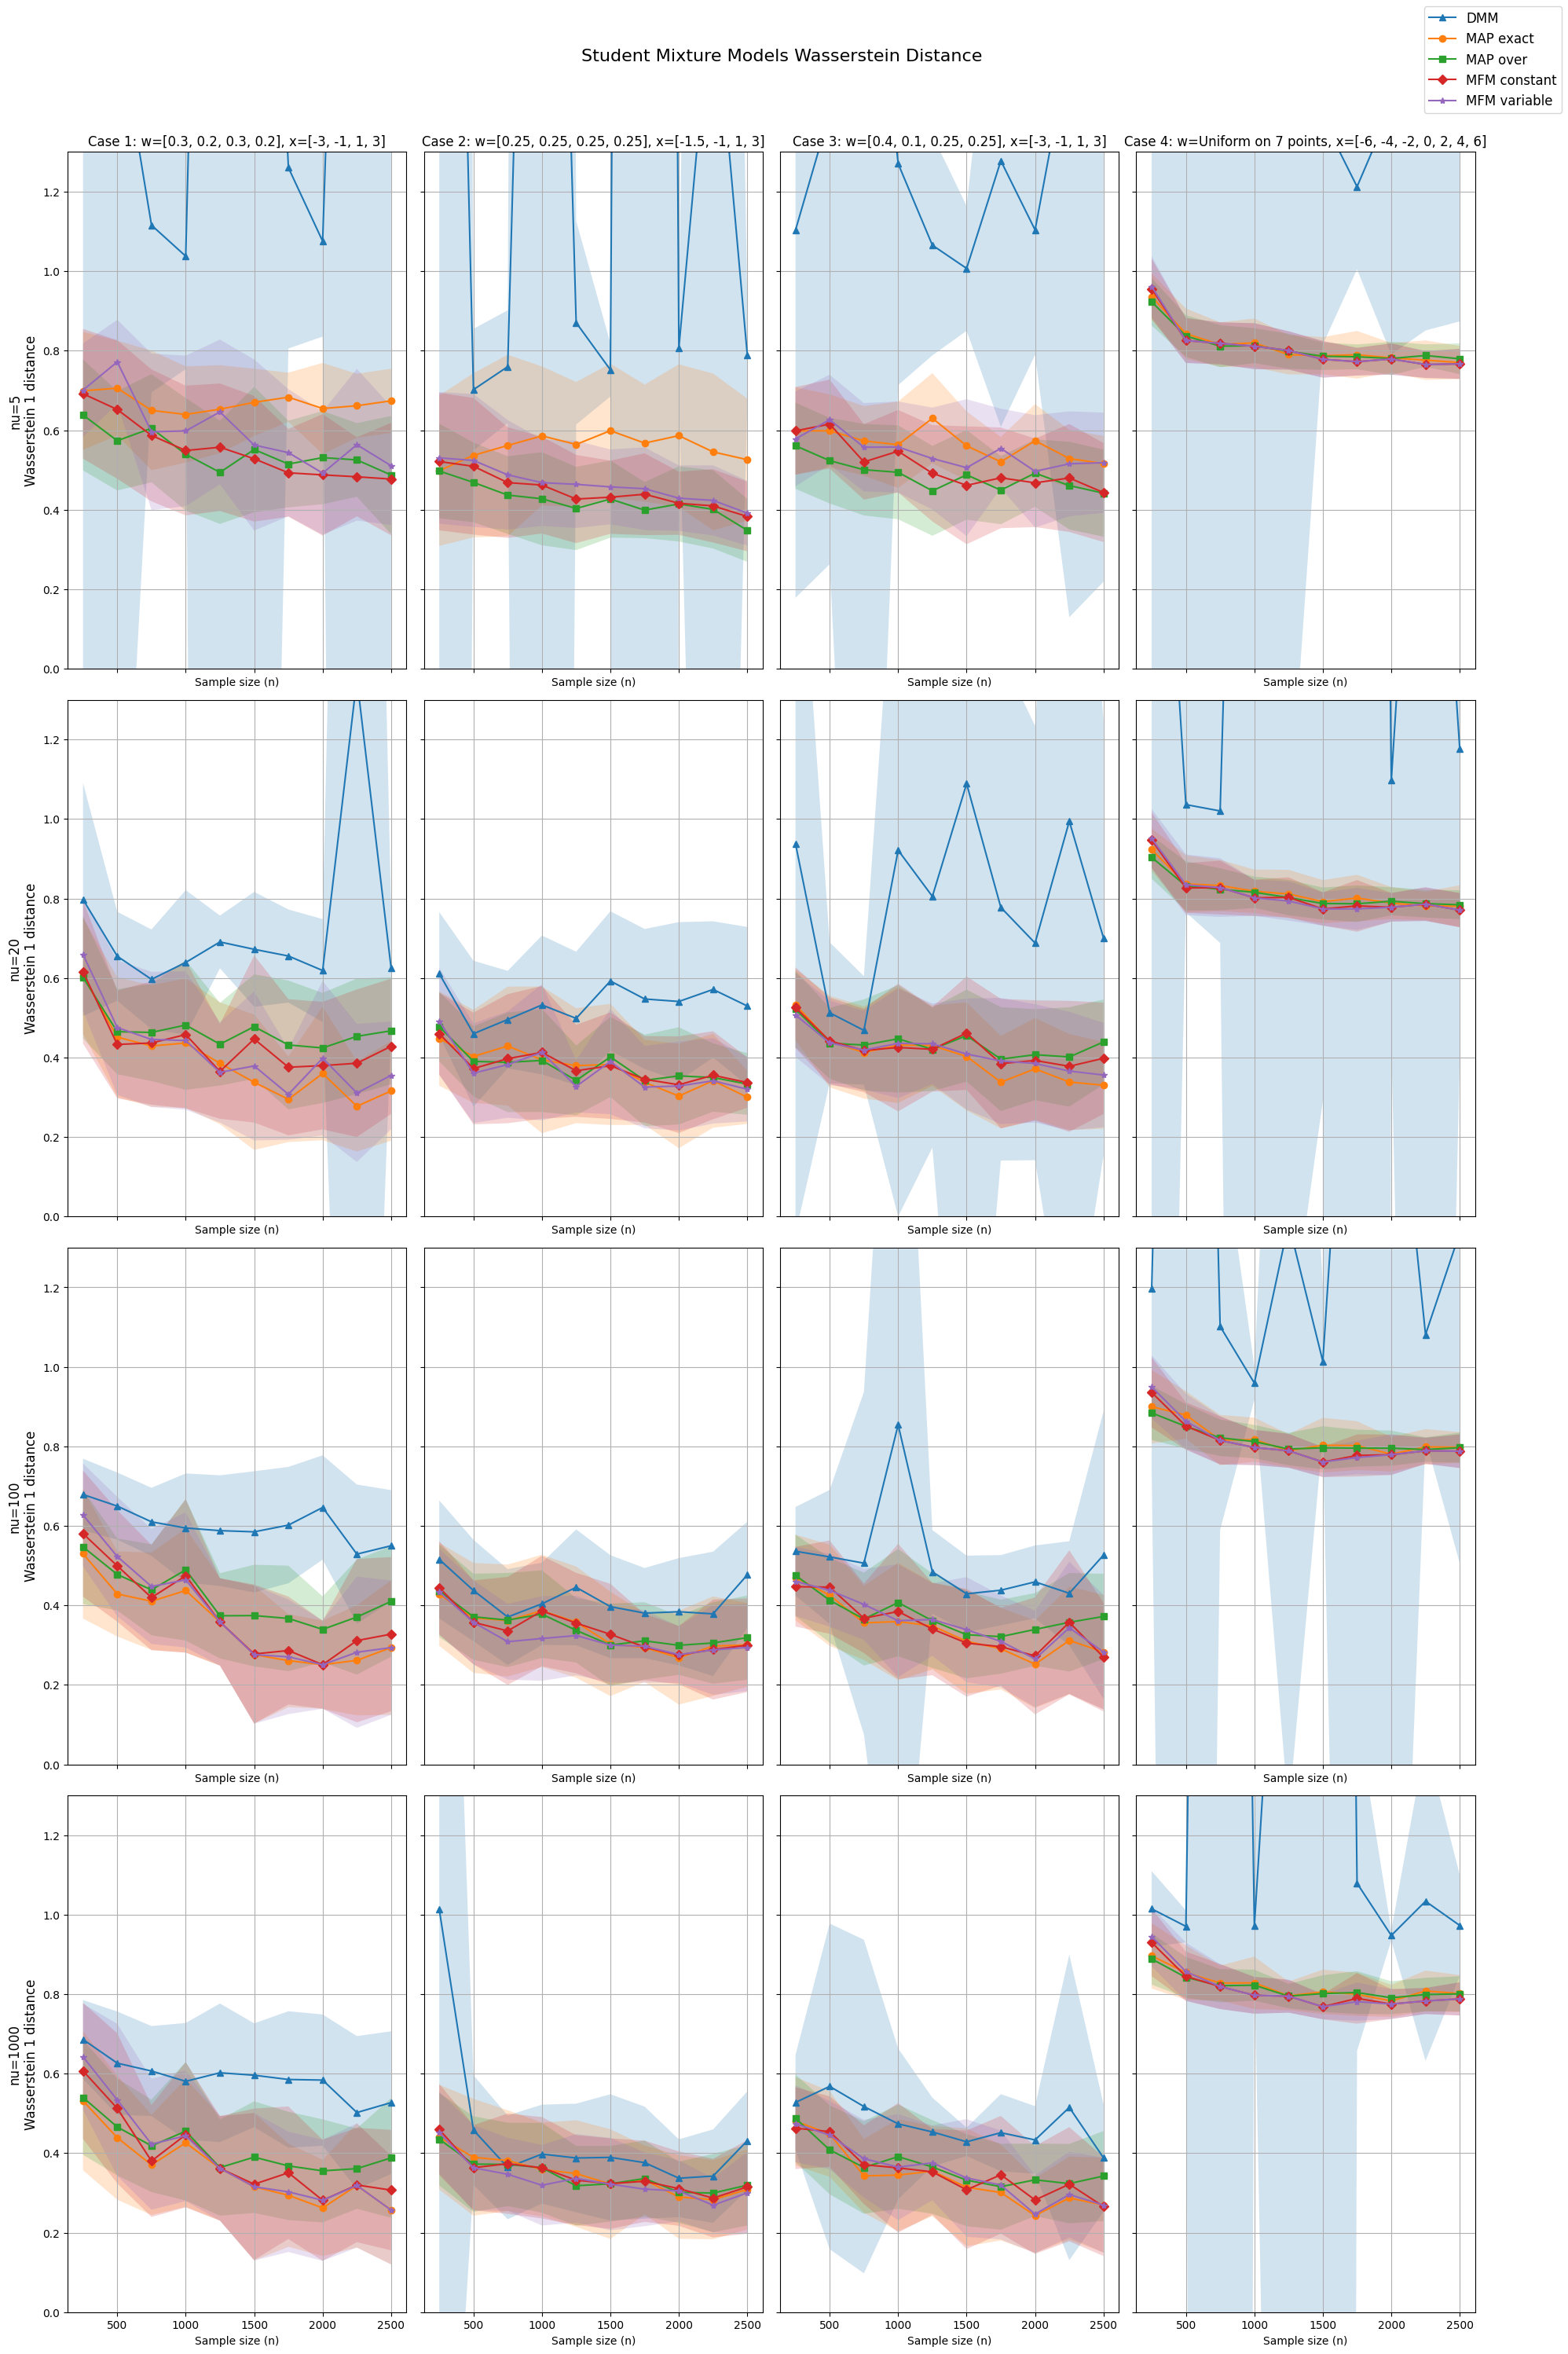

In [23]:
# Installation des packages nécessaires
!pip install cvxpy tqdm

import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from DP import *
from bayes import *
from em_bayes import *
from dmm import DMM
from model_student_mixture import ModelStudentMixture, sample_student_mix
from discrete_rv import wass

# Définition des modèles
nu_values = [5, 20, 100, 1000]
model_list = []
case_descriptions = [
    "Case 1: w=[0.3, 0.2, 0.3, 0.2], x=[-3, -1, 1, 3]",
    "Case 2: w=[0.25, 0.25, 0.25, 0.25], x=[-1.5, -1, 1, 3]",
    "Case 3: w=[0.4, 0.1, 0.25, 0.25], x=[-3, -1, 1, 3]",
    "Case 4: w=Uniform on 7 points, x=[-6, -4, -2, 0, 2, 4, 6]"
]

for nu in nu_values:
    model_list.append(ModelStudentMixture(w=[0.3, 0.2, 0.3, 0.2], x=[-3, -1, 1, 3], std=1, nu=nu))
    model_list.append(ModelStudentMixture(w=[0.25, 0.25, 0.25, 0.25], x=[-1.5, -1, 1, 3], std=1, nu=nu))
    model_list.append(ModelStudentMixture(w=[0.4, 0.1, 0.25, 0.25], x=[-3, -1, 1, 3], std=1, nu=nu))
    model_list.append(ModelStudentMixture(w=np.ones(7)/7, x=2*np.arange(7)-6, std=1, nu=nu))

n_list = 250 * (np.arange(10) + 1)
repeat = 20
wass_list = np.zeros([len(model_list), len(n_list), 5, repeat])

total_iterations = len(model_list) * len(n_list) * repeat
with tqdm(total=total_iterations, desc="Processing") as pbar:
    for m in range(len(model_list)):    
        model = model_list[m]
        kexact = len(model.centers)
        kmax = 2 * kexact 
        kmin = 2
        
        for i, n in enumerate(n_list):         
            for b in range(repeat):
                x = sample_student_mix(model, n, seed=b)
                
                dmm = DMM(k=np.min([kexact, 4]), interval=[-7, 7], sigma=1)    
                dmm_est = dmm.estimate(x)
                map1, map2, bayes1, bayes2 = em_msel(
                    x, 
                    kmin, 
                    kmax, 
                    kexact, 
                    interval=[-6, 6], 
                    lam1=1, 
                    lam2=np.exp(-0.05 * np.log(n)**2 / np.log(np.log(n))), 
                    kappa=1
                )
                
                wass_list[m, i, 0, b] = wass(dmm_est.mean_rv(), model.mean_rv())
                wass_list[m, i, 1, b] = wass(map1.mean_rv(), model.mean_rv())
                wass_list[m, i, 2, b] = wass(map2.mean_rv(), model.mean_rv())
                wass_list[m, i, 3, b] = wass(bayes1.mean_rv(), model.mean_rv())
                wass_list[m, i, 4, b] = wass(bayes2.mean_rv(), model.mean_rv())
                
                pbar.update(1)

# PLOT
wass_mean = wass_list.mean(axis=3)
wass_std = wass_list.std(axis=3)

markers = ['^', 'o', 's', 'D', '*']
name = ['DMM', 'MAP exact', 'MAP over', 'MFM constant', 'MFM variable']

# Définition de la grille de sous-graphiques
num_nu = len(nu_values)
num_cases = len(case_descriptions)
fig, axes = plt.subplots(num_nu, num_cases, figsize=(20, 30), sharex=True, sharey=True)

for m in range(len(model_list)):      
    row = m // num_cases
    col = m % num_cases
    ax = axes[row, col]
    
    # Tracé des différentes méthodes
    for i in range(5): 
        ax.plot(n_list, wass_mean[m, :, i], marker=markers[i], label=name[i])        
        ax.fill_between(
            n_list, 
            wass_mean[m, :, i] - wass_std[m, :, i], 
            wass_mean[m, :, i] + wass_std[m, :, i], 
            alpha=0.2
        )
    
    # Ajout des labels et du titre
    if row == 0:
        ax.set_title(f"{case_descriptions[col]}", fontsize=12)
    if col == 0:
        ax.set_ylabel(f"nu={nu_values[row]}\nWasserstein 1 distance", fontsize=12)
    
    ax.set_xlabel("Sample size (n)", fontsize=10)
    ax.set_ylim(0,1.3)
    ax.grid(True)

# Ajout de la légende commune
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12)

fig.suptitle("Student Mixture Models Wasserstein Distance", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.96])

# Sauvegarde du graphique unique avec la grille
plt.savefig("student_mixture_all_cases_grid.png")
plt.show()